### TFG - Cesar Hernandez Rodriguez
Segundos pasos en las redes neuronales y la bolsa, para este caso buscamos predecir valores y no tendencias

Este script se basa en descargar datos de la bolsa de EEUU, exactamente todos los del índice nasdaq que es uno de los índices más importantes de Estados Unidos, siendo la segunda bolsa de valores automatizada y electronica mas grande del mundo con 3800 compañias. (https://es.wikipedia.org/wiki/NASDAQ)

Para ello usaré la librería QUANDL (https://www.quandl.com/tools/python) que implementa una API para poder descargar los datos de manera sencilla. 

El primer paso será mediante WEB-Scrapping descargar de Wikipedia los tickets de los 500 valores del índice bursatil, después ire recursivamente descargando todos los datos disponibles de los 500 valores desde el 2000 hasta el final del año 2017, estos datos los usare para entrenar la red neuronal y poder predecir el primer trimestre de 2018. La selección de estas fechas se debe al a disponibilidad que ofrece la librería Quandl ya que al usarla de forma gratuita no se puede descargar los históricos de todos los datos ni todo los datos más actuales, de todas formas aún asi vamos a tener problemas ya que solo he conseguido de 485 de 500 activos y de algunos no tenemos unos datos históricos tan extensos como lo que buscabamos.

A mayores una vez descagardo los datos (ya que tarda mucho) los voy a guardar dentro de mi ordenador serializandolo con el paquete Pickle (http://pyspanishdoc.sourceforge.net/lib/module-pickle.html)

In [1]:
# Import predefinifods
import pandas as pd
import numpy as np
import random
from math import *
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from time import time
import matplotlib.pyplot as plt
from collections import Counter

# Importa descaga de datos
import quandl

# Import serializar
import pickle

# Import red Neuronal
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
import keras.backend as K

# Conteo
from collections import Counter

Using TensorFlow backend.


In [11]:
#Tengo dos bases de datos con todos los tickers del indice nasdaq y todos los tickers
# que tiene mi base de datos y extraigo solo los que tengo
def get_tickers_sample_nasdaq():
    tickers_wiki_quandl = pd.read_csv('WIKI_PRICES.csv')['ticker']
    tickers_nasdaq = pd.read_csv('nasdaq-listed-symbols.csv')['Symbol']
    
    tickersQuandl = []    
    tickers = []
    for i in range(len(tickers_nasdaq)):
        word = tickers_nasdaq[i]
        for j in range(len(tickers_wiki_quandl)):
            if word == tickers_wiki_quandl[j]:
                tickers.append(word)
    
    tickers = random.choices(tickers, k=20)
    
    for tick in tickers:
        tickersQuandl.append("WIKI/"+tick)
    
    return tickers, tickersQuandl

# a,b = get_tickers_sample_nasdaq()

In [15]:
# Descargo los datos de la API Quandl, para ello uso el conjunto de datos que me ofrece WIKI/ que se puede ver
# en la página de la libreria y me registro en la pagina de forma gratuita dandome una key.
# me devuelve una lista con todos los datos posibles de ese activo, yo guardo todos y por separado los de cierre
# Aunque solo me interese los de cierre quiero guardar todos los datos por si en una extension de este trabajo se queire 
# usar cualquier otro dato
# Para no tener que realizar la parte de descarga cada vez que se inicia el programa se ha habilitado la descarga
# y guardado de datos en una carpeta datos que ya debe crearse antes. Los datos se guardan serializados.

def get_data(verbose):
    quandl.ApiConfig.api_key = 'WgQVD8Npfox1MN7SV3Nm'
    tickers, tickersQuandl = get_tickers_sample_nasdaq()
    
    if verbose: print(" ****Empezamos a descargar los datos****\n")
    
    datos = {}
    start_time = time()
    long = len(tickersQuandl)
    i = 0
    # Las fechas elegidas son esas para poder tener una gran cantidad de datos historicos y
    # que justo se complementen con las fechas de tipo test, al hacer Medias Moviles se pierden muchos datos
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos")
        #aux=quandl.get(ticker,start_date="2000-01-01",end_date="2016-12-31")
        aux=quandl.get(ticker,start_date="2008-01-01",end_date="2016-12-31")
        datos[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose = {}
    for key in datos:
        datosClose[key] = datos[key]["Adj. Close"]
    
    elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos: %0.10f segundos." % elapsed_time)
    
    if verbose: print("\n ****Empezamos a descargar los datos test****\n")
    
    # Procedo a hacer las mismas operaciones para el conjunto TEST
    datos_test = {}
    i = 0
    long = len(tickersQuandl)
    start_time = time()    
    for ticker in tickersQuandl:
        if i % 2 == 0 and verbose: print("LLeva descargados el ",i/long *100,"% de los datos test")
        aux=quandl.get(ticker,start_date="2016-11-01",end_date="2020-12-31")
        datos_test[ticker[5:len(ticker)]] = aux
        i = i + 1
    
    datosClose_test = {}
    for key in datos_test:
        datosClose_test[key] = datos_test[key]["Adj. Close"]
    
        elapsed_time = time() - start_time
    if verbose: print("\nHa tardado en descargar los datos test: %0.10f segundos." % elapsed_time)
    if verbose: print("\n")
    
    # Solo cogemos los datos que nos da la aplicacion
    # ya que hay activos que no tenemos su valor en esas fechas o tenemos muy pocos datos

    quitar = []
    for key in tickers:
        if datosClose_test[key].empty:
            if verbose == True : print("Restriccion de vacio",key) 
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
        elif len(datosClose_test[key]) < 300:
            if verbose == True :  print("Restriccion de longitud",key)
            datos.pop(key,None)
            datosClose.pop(key,None)
            datos_test.pop(key,None)
            datosClose_test.pop(key,None)
            quitar.append(key)
            
    for key in quitar:
        tickers.remove(key)
    
    # Guardamos los datos y serializamos
    pickle.dump(tickers, open("datos/tickers_nasdaq.p", "wb"))
    pickle.dump(tickersQuandl, open("datos/tickersQuandl_nasdaq.p", "wb"))
    pickle.dump(datos, open("datos/nasdaq.p", "wb"))
    pickle.dump(datosClose, open("datos/nasdaqClose.p", "wb"))
    pickle.dump(datos_test, open("datos/nasdaq_test.p", "wb"))
    pickle.dump(datosClose_test, open("datos/nasdaqClose_test.p", "wb"))
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

In [13]:
# Si los datos ya han sido descargados con esta funcion los cargo gracias a la libreria pickles
def get_data_load(verbose):
    if verbose: print(" ****Empezamos a cargar los datos****\n")
    tickers = pickle.load(open("datos/tickers_nasdaq.p", "rb" ))
    tickersQuandl = pickle.load(open("datos/tickersQuandl_nasdaq.p", "rb" ))
    datos = pickle.load(open("datos/nasdaq.p", "rb" ))
    datosClose = pickle.load(open("datos/nasdaqClose.p", "rb" ))
    if verbose: print(" ****Cargados los datos****\n")
    
    if verbose: print("\n ****Empezamos a cargar los datos test****\n")
    datos_test = pickle.load(open("datos/nasdaq_test.p", "rb" ))
    datosClose_test = pickle.load(open("datos/nasdaqClose_test.p", "rb" ))
    if verbose: print(" ****Cargados los datos test****\n")
    
    return tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test

# Para imprimir cualquier conjunto tipo Serie temporal del conjunto de datos base uso esta funcion
def plot_datos(datosClose,nombre,test):
    datosClose[nombre].plot(figsize=(12,5),grid=True)
    plt.title('{} {}\n'.format(nombre,test))
    plt.ylabel('Precio de Cierre')
    plt.xlabel('Fecha')
    plt.show()
    

In [16]:
datos_descargados = False
if datos_descargados:
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test= get_data_load(True)
else : 
    tickers, tickersQuandl, datos, datosClose, datos_test, datosClose_test = get_data(True)

 ****Empezamos a descargar los datos****

LLeva descargados el  0.0 % de los datos
LLeva descargados el  10.0 % de los datos
LLeva descargados el  20.0 % de los datos
LLeva descargados el  30.0 % de los datos
LLeva descargados el  40.0 % de los datos
LLeva descargados el  50.0 % de los datos
LLeva descargados el  60.0 % de los datos
LLeva descargados el  70.0 % de los datos
LLeva descargados el  80.0 % de los datos
LLeva descargados el  90.0 % de los datos

Ha tardado en descargar los datos: 30.1960670948 segundos.

 ****Empezamos a descargar los datos test****

LLeva descargados el  0.0 % de los datos test
LLeva descargados el  10.0 % de los datos test
LLeva descargados el  20.0 % de los datos test
LLeva descargados el  30.0 % de los datos test
LLeva descargados el  40.0 % de los datos test
LLeva descargados el  50.0 % de los datos test
LLeva descargados el  60.0 % de los datos test
LLeva descargados el  70.0 % de los datos test
LLeva descargados el  80.0 % de los datos test
LLeva des

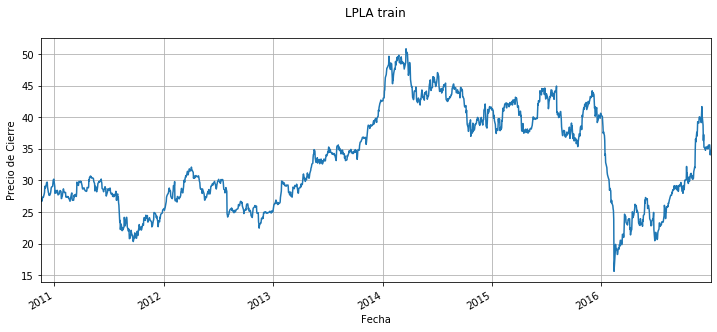

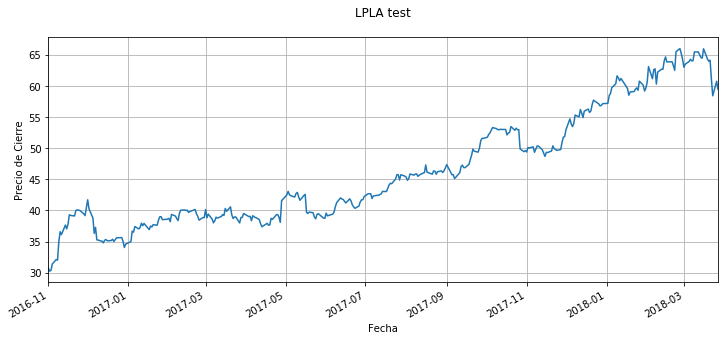

In [17]:
# Grafico un activo aleatorio que luego predecire
# Se tiene el gráfico con el que se creara el modelo y los datos sobre los que se va a testear
ran = random.randint(0,len(tickers)-1)
plot_datos(datosClose,tickers[ran],"train")
plot_datos(datosClose_test,tickers[ran],"test")

In [19]:
# Para crear los atributos que voy a meter en la red Neuronal uso esta funcion, mis atributos son
# Dos medias moviles, una de 30 dias y otra de 15 para hacer la simulacion con los datos de un mes y la mitad de mes
# por ulitmo creo un oscilador de la media movil de 30 dias donde resto los valores son separacion de 30 dias
def differences(x):
    return x[-1] - x[0]

def create_features(datosClose,days1,days2):
    X = pd.DataFrame()
    data = pd.DataFrame()
    data['Adj. Close'] = datosClose.values
    
    indices = datosClose.index
    
    X['MA_{}'.format(days1)] = data['Adj. Close'].rolling(window=days1).mean()
    X['MA_{}'.format(days2)] = data['Adj. Close'].rolling(window=days2).mean()
    X['Diferencia'] = data['Adj. Close'].rolling(window=days2).apply(differences,raw=True) 
    X = X[days2:len(X)-1].reset_index()
    X.drop(['index'], axis='columns', inplace=True)

    return X, indices[(days2+1):len(indices)]

# Creo tambien timestep de 30 dias (igual que la media movil) para la RED NEURONAL
def cut_timestep(x,y,time):
    
    Xt = []
    yt = []
    index_time = []

    for i in range(timeStep, len(x)):
        Xt.append(x[i-timeStep:i,:])
        yt.append(y.iloc[i,0])
        index_time.append(time[i])

    return np.array(Xt), np.array(yt), pd.Series(index_time)

    


In [20]:
# A parte de la creacion de atributos
index = ran
timeStep = 20 # longitud de secuencias que se hacen en cada iteracion de la red

# Extraigo los atributos de los datos y los preparo para meterlos a la red neuronal

X, ind_time = create_features(datosClose[tickers[index]],1,20)
Y = pd.DataFrame(datosClose[tickers[index]].values[21:len(datosClose[tickers[index]])])
X = X.to_numpy()

# Normalizar
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Creacion de los timestep
Xt, yt, index_time = cut_timestep(X_scaled,Y,ind_time)

# Split de en conjunto de prueba y entrenamiento para la red neuronal
P=yt.shape[0]
indices=np.arange(P,dtype=int)
np.random.shuffle(indices)
sequences_train=indices[0:int(P*2/3)]
sequences_test=indices[int(P*2/3):]
X_train, X_test, y_train, y_test = Xt[sequences_train],Xt[sequences_test],yt[sequences_train],yt[sequences_test]


# Creamos los atributos, normalizamos y creamos los timestep para los datos test
ticket_uso = tickers[index]
Xtesteo, ind_time_t = create_features(datosClose_test[tickers[index]],10,20)
Ytesteo = pd.DataFrame(datosClose_test[tickers[index]].values[21:len(datosClose_test[tickers[index]])])
Xtesteo = Xtesteo.to_numpy()

# Normalizar
scaler = MinMaxScaler()
Xtesteo_scaled = scaler.fit_transform(Xtesteo)
Xtt, ytt, index_time_t = cut_timestep(Xtesteo_scaled,Ytesteo,ind_time_t)

print("Voy a predecir el activo ",ticket_uso)



Voy a predecir el activo  LPLA


In [21]:
# Calculates a successfull ratio using less relative error than a maximum
def porcentaje_margen(y_true, y_pred):
    margen = 0.05
    yy = K.sum(K.cast(K.less(K.abs((y_pred/y_true)-1.0), margen), dtype=float))
    return yy/K.cast(K.shape(y_pred)[0], dtype=float)

In [22]:
# Creacion de la red neural LSTM

model = Sequential()
model.add(LSTM(8, input_shape=(20,3),return_sequences=True))
model.add(LSTM(units = 4,return_sequences = False))
model.add(Dense(1)) 
model.compile(optimizer="adam",loss='mse',metrics=[porcentaje_margen]) 
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 8)             384       
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 208       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 597
Trainable params: 597
Non-trainable params: 0
_________________________________________________________________


In [23]:
history_LSTM = model.fit(X_train,
                  y_train,
                  epochs=500,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

Train on 999 samples, validate on 500 samples
Epoch 1/500
999/999 [==============================] - 2s 2ms/step - loss: 1133.5310 - porcentaje_margen: 0.0000e+00 - val_loss: 1139.3176 - val_porcentaje_margen: 0.0000e+00
Epoch 2/500
999/999 [==============================] - 1s 983us/step - loss: 1079.0764 - porcentaje_margen: 0.0000e+00 - val_loss: 1087.9900 - val_porcentaje_margen: 0.0000e+00
Epoch 3/500
999/999 [==============================] - 1s 945us/step - loss: 1032.0120 - porcentaje_margen: 0.0000e+00 - val_loss: 1042.9986 - val_porcentaje_margen: 0.0000e+00
Epoch 4/500
999/999 [==============================] - 1s 909us/step - loss: 998.3434 - porcentaje_margen: 0.0000e+00 - val_loss: 1020.6252 - val_porcentaje_margen: 0.0000e+00
Epoch 5/500
999/999 [==============================] - 1s 829us/step - loss: 979.8530 - porcentaje_margen: 0.0000e+00 - val_loss: 1004.3356 - val_porcentaje_margen: 0.0000e+00
Epoch 6/500
999/999 [==============================] - 1s 926us/step - lo

999/999 [==============================] - 1s 895us/step - loss: 610.0593 - porcentaje_margen: 0.0000e+00 - val_loss: 631.6470 - val_porcentaje_margen: 0.0000e+00
Epoch 48/500
999/999 [==============================] - 1s 848us/step - loss: 603.2671 - porcentaje_margen: 0.0000e+00 - val_loss: 624.7260 - val_porcentaje_margen: 0.0000e+00
Epoch 49/500
999/999 [==============================] - 1s 783us/step - loss: 596.5188 - porcentaje_margen: 0.0000e+00 - val_loss: 617.8485 - val_porcentaje_margen: 0.0000e+00
Epoch 50/500
999/999 [==============================] - 1s 825us/step - loss: 589.8343 - porcentaje_margen: 0.0000e+00 - val_loss: 611.0799 - val_porcentaje_margen: 0.0000e+00
Epoch 51/500
999/999 [==============================] - 1s 836us/step - loss: 583.2216 - porcentaje_margen: 0.0000e+00 - val_loss: 604.3028 - val_porcentaje_margen: 0.0000e+00
Epoch 52/500
999/999 [==============================] - 1s 850us/step - loss: 576.6379 - porcentaje_margen: 0.0000e+00 - val_loss: 59

999/999 [==============================] - 1s 918us/step - loss: 352.5089 - porcentaje_margen: 9.7656e-04 - val_loss: 368.3996 - val_porcentaje_margen: 0.0000e+00
Epoch 94/500
999/999 [==============================] - 1s 865us/step - loss: 348.0395 - porcentaje_margen: 9.7656e-04 - val_loss: 363.8385 - val_porcentaje_margen: 0.0000e+00
Epoch 95/500
999/999 [==============================] - 1s 839us/step - loss: 343.6250 - porcentaje_margen: 9.7656e-04 - val_loss: 359.2635 - val_porcentaje_margen: 0.0000e+00
Epoch 96/500
999/999 [==============================] - 1s 882us/step - loss: 339.2315 - porcentaje_margen: 9.7656e-04 - val_loss: 354.7926 - val_porcentaje_margen: 0.0000e+00
Epoch 97/500
999/999 [==============================] - 1s 901us/step - loss: 334.8863 - porcentaje_margen: 9.7656e-04 - val_loss: 350.3068 - val_porcentaje_margen: 0.0000e+00
Epoch 98/500
999/999 [==============================] - 1s 847us/step - loss: 330.5648 - porcentaje_margen: 0.0000e+00 - val_loss: 34

999/999 [==============================] - 1s 889us/step - loss: 184.2155 - porcentaje_margen: 0.0498 - val_loss: 194.6123 - val_porcentaje_margen: 0.0422
Epoch 142/500
999/999 [==============================] - 1s 861us/step - loss: 181.6303 - porcentaje_margen: 0.0488 - val_loss: 191.9402 - val_porcentaje_margen: 0.0480
Epoch 143/500
999/999 [==============================] - 1s 932us/step - loss: 179.0947 - porcentaje_margen: 0.0537 - val_loss: 189.2768 - val_porcentaje_margen: 0.0531
Epoch 144/500
999/999 [==============================] - 1s 905us/step - loss: 176.5659 - porcentaje_margen: 0.0631 - val_loss: 186.6571 - val_porcentaje_margen: 0.0590
Epoch 145/500
999/999 [==============================] - 1s 925us/step - loss: 174.0646 - porcentaje_margen: 0.0654 - val_loss: 184.0146 - val_porcentaje_margen: 0.0590
Epoch 146/500
999/999 [==============================] - 1s 877us/step - loss: 171.6206 - porcentaje_margen: 0.0718 - val_loss: 181.4457 - val_porcentaje_margen: 0.0629


999/999 [==============================] - 1s 794us/step - loss: 95.9956 - porcentaje_margen: 0.1426 - val_loss: 101.5451 - val_porcentaje_margen: 0.1371
Epoch 190/500
999/999 [==============================] - 1s 759us/step - loss: 94.8542 - porcentaje_margen: 0.1539 - val_loss: 100.3247 - val_porcentaje_margen: 0.1430
Epoch 191/500
999/999 [==============================] - 1s 785us/step - loss: 93.7568 - porcentaje_margen: 0.1603 - val_loss: 99.1204 - val_porcentaje_margen: 0.1547
Epoch 192/500
999/999 [==============================] - 1s 799us/step - loss: 92.6753 - porcentaje_margen: 0.1667 - val_loss: 97.9911 - val_porcentaje_margen: 0.1566
Epoch 193/500
999/999 [==============================] - 1s 750us/step - loss: 91.6430 - porcentaje_margen: 0.1611 - val_loss: 96.8383 - val_porcentaje_margen: 0.1590
Epoch 194/500
999/999 [==============================] - 1s 770us/step - loss: 90.6094 - porcentaje_margen: 0.1755 - val_loss: 95.7090 - val_porcentaje_margen: 0.1609
Epoch 195/

999/999 [==============================] - 1s 867us/step - loss: 64.5775 - porcentaje_margen: 0.1006 - val_loss: 66.3962 - val_porcentaje_margen: 0.1027
Epoch 239/500
999/999 [==============================] - 1s 842us/step - loss: 64.3271 - porcentaje_margen: 0.1041 - val_loss: 66.0845 - val_porcentaje_margen: 0.0988
Epoch 240/500
999/999 [==============================] - 1s 855us/step - loss: 64.0971 - porcentaje_margen: 0.1021 - val_loss: 65.8040 - val_porcentaje_margen: 0.0910
Epoch 241/500
999/999 [==============================] - 1s 888us/step - loss: 63.8647 - porcentaje_margen: 0.1011 - val_loss: 65.5113 - val_porcentaje_margen: 0.0891
Epoch 242/500
999/999 [==============================] - 1s 877us/step - loss: 63.6493 - porcentaje_margen: 0.1027 - val_loss: 65.2286 - val_porcentaje_margen: 0.0910
Epoch 243/500
999/999 [==============================] - 1s 878us/step - loss: 63.4460 - porcentaje_margen: 0.0963 - val_loss: 64.9849 - val_porcentaje_margen: 0.0930
Epoch 244/50

999/999 [==============================] - 1s 865us/step - loss: 32.4728 - porcentaje_margen: 0.4519 - val_loss: 34.1140 - val_porcentaje_margen: 0.4176
Epoch 288/500
999/999 [==============================] - 1s 817us/step - loss: 31.4253 - porcentaje_margen: 0.4696 - val_loss: 33.0570 - val_porcentaje_margen: 0.4332
Epoch 289/500
999/999 [==============================] - 1s 877us/step - loss: 30.3918 - porcentaje_margen: 0.4768 - val_loss: 32.0112 - val_porcentaje_margen: 0.4332
Epoch 290/500
999/999 [==============================] - 1s 875us/step - loss: 29.3933 - porcentaje_margen: 0.4905 - val_loss: 30.9529 - val_porcentaje_margen: 0.4332
Epoch 291/500
999/999 [==============================] - 1s 853us/step - loss: 28.4375 - porcentaje_margen: 0.4958 - val_loss: 29.9358 - val_porcentaje_margen: 0.4605
Epoch 292/500
999/999 [==============================] - 1s 860us/step - loss: 27.5296 - porcentaje_margen: 0.5052 - val_loss: 29.0134 - val_porcentaje_margen: 0.4703
Epoch 293/50

999/999 [==============================] - 1s 908us/step - loss: 8.5658 - porcentaje_margen: 0.6659 - val_loss: 8.7836 - val_porcentaje_margen: 0.6656
Epoch 337/500
999/999 [==============================] - 1s 894us/step - loss: 8.2062 - porcentaje_margen: 0.6839 - val_loss: 8.6729 - val_porcentaje_margen: 0.6469
Epoch 338/500
999/999 [==============================] - 1s 907us/step - loss: 8.0150 - porcentaje_margen: 0.6784 - val_loss: 8.3716 - val_porcentaje_margen: 0.6645
Epoch 339/500
999/999 [==============================] - 1s 893us/step - loss: 7.8493 - porcentaje_margen: 0.6874 - val_loss: 8.1183 - val_porcentaje_margen: 0.6602
Epoch 340/500
999/999 [==============================] - 1s 909us/step - loss: 7.7108 - porcentaje_margen: 0.6825 - val_loss: 8.0751 - val_porcentaje_margen: 0.6633
Epoch 341/500
999/999 [==============================] - 1s 876us/step - loss: 7.4348 - porcentaje_margen: 0.6883 - val_loss: 7.7333 - val_porcentaje_margen: 0.6734
Epoch 342/500
999/999 [=

Epoch 386/500
999/999 [==============================] - 1s 821us/step - loss: 2.9292 - porcentaje_margen: 0.8315 - val_loss: 2.9981 - val_porcentaje_margen: 0.7973
Epoch 387/500
999/999 [==============================] - 1s 912us/step - loss: 2.9236 - porcentaje_margen: 0.8301 - val_loss: 2.9640 - val_porcentaje_margen: 0.8062
Epoch 388/500
999/999 [==============================] - 1s 959us/step - loss: 2.8126 - porcentaje_margen: 0.8364 - val_loss: 2.8819 - val_porcentaje_margen: 0.8062
Epoch 389/500
999/999 [==============================] - 1s 891us/step - loss: 2.8313 - porcentaje_margen: 0.8359 - val_loss: 2.8528 - val_porcentaje_margen: 0.8219
Epoch 390/500
999/999 [==============================] - 1s 860us/step - loss: 2.7352 - porcentaje_margen: 0.8383 - val_loss: 2.8246 - val_porcentaje_margen: 0.8266
Epoch 391/500
999/999 [==============================] - 1s 813us/step - loss: 2.6810 - porcentaje_margen: 0.8486 - val_loss: 2.7859 - val_porcentaje_margen: 0.8227
Epoch 392/

Epoch 436/500
999/999 [==============================] - 1s 966us/step - loss: 1.5946 - porcentaje_margen: 0.8626 - val_loss: 1.8292 - val_porcentaje_margen: 0.8469
Epoch 437/500
999/999 [==============================] - 1s 942us/step - loss: 1.6098 - porcentaje_margen: 0.8721 - val_loss: 1.5720 - val_porcentaje_margen: 0.8641
Epoch 438/500
999/999 [==============================] - 1s 877us/step - loss: 1.5804 - porcentaje_margen: 0.8670 - val_loss: 1.5537 - val_porcentaje_margen: 0.8602
Epoch 439/500
999/999 [==============================] - 1s 842us/step - loss: 1.6520 - porcentaje_margen: 0.8631 - val_loss: 1.5434 - val_porcentaje_margen: 0.8621
Epoch 440/500
999/999 [==============================] - 1s 899us/step - loss: 1.5463 - porcentaje_margen: 0.8774 - val_loss: 1.5120 - val_porcentaje_margen: 0.8738
Epoch 441/500
999/999 [==============================] - 1s 917us/step - loss: 1.5241 - porcentaje_margen: 0.8770 - val_loss: 1.5276 - val_porcentaje_margen: 0.8719
Epoch 442/

Epoch 486/500
999/999 [==============================] - 1s 731us/step - loss: 1.1413 - porcentaje_margen: 0.9053 - val_loss: 1.1127 - val_porcentaje_margen: 0.8914
Epoch 487/500
999/999 [==============================] - 1s 777us/step - loss: 1.1698 - porcentaje_margen: 0.8984 - val_loss: 1.1273 - val_porcentaje_margen: 0.8973
Epoch 488/500
999/999 [==============================] - 1s 772us/step - loss: 1.1084 - porcentaje_margen: 0.9033 - val_loss: 1.0854 - val_porcentaje_margen: 0.8973
Epoch 489/500
999/999 [==============================] - 1s 814us/step - loss: 1.1197 - porcentaje_margen: 0.9072 - val_loss: 1.1029 - val_porcentaje_margen: 0.8992
Epoch 490/500
999/999 [==============================] - 1s 884us/step - loss: 1.0987 - porcentaje_margen: 0.9076 - val_loss: 1.1422 - val_porcentaje_margen: 0.9020
Epoch 491/500
999/999 [==============================] - 1s 873us/step - loss: 1.1165 - porcentaje_margen: 0.9057 - val_loss: 1.1017 - val_porcentaje_margen: 0.8953
Epoch 492/

#### Si vemos que necesitamos mas epocas corremos este codigo
history_LSTM = model.fit(X_train,
                  y_train,
                  initial_epoch=500,
                  epochs=1000,
                  verbose=1,
                  validation_data=(X_test,y_test)) 

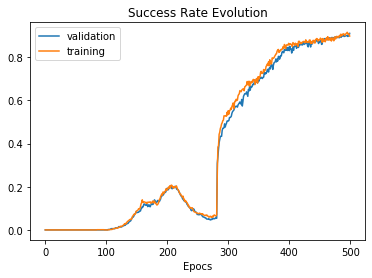

In [24]:
plt.plot(history_LSTM.epoch,history_LSTM.history['val_porcentaje_margen'],label='validation')
plt.plot(history_LSTM.epoch,history_LSTM.history['porcentaje_margen'],label="training")
plt.legend()
plt.title('Success Rate Evolution')
plt.xlabel('Epocs')
plt.show()

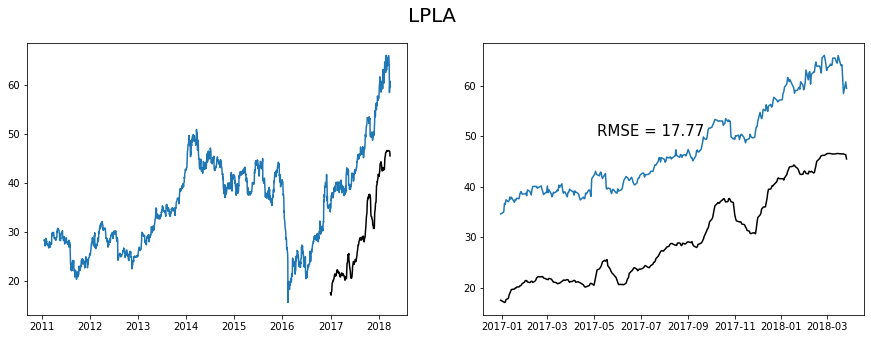

In [25]:
# Calculo la prediccion para mi conjunto test
predicted_stock_price = pd.DataFrame(model.predict(Xtt))

# Junto la grafica de los datos de entrenamiento y test para ver cuanto a variado en terminos generales
indicedetiempo = pd.concat((index_time,index_time_t), axis = 0)
yt = pd.DataFrame(yt) ; ytt = pd.DataFrame(ytt)
stock_real_value = pd.concat((yt,ytt),axis = 0)

# Calculo el RMSE para ver el error de prediccion
rmse = sqrt(mean_squared_error(ytt, predicted_stock_price))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 5))
fig.suptitle(tickers[index],fontsize = 20)
# Plot de todo el grafico
ax1.plot(indicedetiempo,stock_real_value)
ax1.plot(index_time_t,predicted_stock_price, color = "black")

# Plot de solo la parte que hemos hecho el predict
ax2.plot(index_time_t,ytt)
ax2.plot(index_time_t,predicted_stock_price, color = "black")
ax2.annotate('RMSE = %.2f'% rmse, (index_time_t[40], ytt.iloc[40]), xytext=(50, 50), 
            textcoords='offset points',fontsize = 15)

plt.show()

Queremos realizar una inversion de 100000 euros en el activo que hemos estudiado, nos basamos en un margen entre la diferencia de los dos precios adyacentes para saber si comprar, vender o mantener.
Tenemos 3 posibles caminos, comprar solo a la alza, comprar solo a la baja o comprar a la alza y a la baja.
Ciertos actios tienen caidas o subidas muy bruscas imposibles de predecir porque no tienen que ver con los datos historicos si no con la situacion y el contexto que vive la empresa

In [26]:
pd.options.display.max_rows = 10000 # Para poder ver todos los movimientos

# Es un margen movil, segun lo que busquemos
margen = 0.00005
diferencias = np.zeros(len(predicted_stock_price)-1)
for i in range(len(diferencias)):
    diferencias[i] = (predicted_stock_price.iloc[i+1,0]-predicted_stock_price.iloc[i,0])/max(predicted_stock_price.iloc[i+1,0],predicted_stock_price.iloc[i,0])
    if diferencias[i] > margen:
        diferencias[i] = 1
    elif diferencias[i] < -margen:
        diferencias[i] = -1
    else:
        diferencias[i] = 0
    
print(Counter(diferencias))

Counter({1.0: 185, -1.0: 119, 0.0: 5})


In [27]:
# Si solo queremos comrpar a la alza
# Estado es lo que hay que hacer ese dia
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_alza = pd.DataFrame(columns = ["presupuesto","acciones","estado","valor","pred","dif"],index = index_time_t)
movimientos_alza.presupuesto[0] = 100000 ; movimientos_alza.acciones[0] = 0 ; movimientos_alza.estado[0] = 0
movimientos_alza.valor[0] = ytt.iloc[0,0] ; movimientos_alza.pred[0] = predicted_stock_price.iloc[0,0]

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_alza.acciones[i-1] == 0:
            movimientos_alza.estado[i] = 1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] % ytt.iloc[i,0]
            movimientos_alza.acciones[i] = movimientos_alza.presupuesto[i-1] // ytt.iloc[i,0]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_alza.acciones[i-1] > 0:
            movimientos_alza.estado[i] = -1
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1] + movimientos_alza.acciones[i-1] * ytt.iloc[i,0]
            movimientos_alza.acciones[i] = 0
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]
        else:
            movimientos_alza.estado[i] = 0
            movimientos_alza.presupuesto[i] = movimientos_alza.presupuesto[i-1]
            movimientos_alza.acciones[i] = movimientos_alza.acciones[i-1]
            movimientos_alza.valor[i] = ytt.iloc[i,0]
            movimientos_alza.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_alza.dif[i] = diferencias[i]

            
movimientos_alza = movimientos_alza.drop(movimientos_alza.tail(1).index)
print(movimientos_alza.tail(1))
valor_f_alza = movimientos_alza.presupuesto[len(movimientos_alza)-1] + movimientos_alza.valor[len(movimientos_alza)-1] * movimientos_alza.acciones[len(movimientos_alza)-1]
ganancia_alza = valor_f_alza - 100000
print('Valor Final = %.2f' % valor_f_alza)
print('Ganancia con margen = %.2f' % ganancia_alza)

           presupuesto acciones estado  valor     pred dif
2018-03-26      121046        0      0  60.74  46.3059  -1
Valor Final = 121045.83
Ganancia con margen = 21045.83


In [28]:
print(movimientos_alza)

           presupuesto acciones estado    valor     pred  dif
2016-12-30      100000        0      0  34.5907  17.5251  NaN
2017-01-03      100000        0      0  34.9837  17.1903   -1
2017-01-04      1.3564     2726      1  36.6833  17.0872    1
2017-01-05      1.3564     2726      0  36.5065  17.1336    1
2017-01-06      1.3564     2726      0  37.4103  17.6538    1
2017-01-09      1.3564     2726      0  37.0271  17.8844    1
2017-01-10      1.3564     2726      0  37.2433  18.5422    1
2017-01-11      1.3564     2726      0  37.9506  18.9145    1
2017-01-12      1.3564     2726      0  37.5478  19.2341    1
2017-01-13      1.3564     2726      0  37.9113  19.6421    1
2017-01-17      1.3564     2726      0  36.9092   19.736    1
2017-01-18      1.3564     2726      0  37.4889  19.9427    0
2017-01-19      1.3564     2726      0  37.3513  19.9419    1
2017-01-20      1.3564     2726      0  37.7148  20.1299    1
2017-01-23      1.3564     2726      0  37.6166  20.1662    1
2017-01-

In [30]:
# Compro a la alza y a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_ab= pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_ab.presupuesto[0] = 100000 % ytt.iloc[0,0] ; movimientos_ab.acciones[0] = 100000 // ytt.iloc[0,0] ; movimientos_ab.acciones_debo[0] = 0 ;
movimientos_ab.estado[0] = 0 ; movimientos_ab.valor[0] = ytt.iloc[0,0] ;
movimientos_ab.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_ab.acciones[i-1] == 0:
            movimientos_ab.estado[i] = 1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         % ytt.iloc[i,0])
            movimientos_ab.acciones[i] = ((movimientos_ab.presupuesto[i-1] - (movimientos_ab.acciones_debo[i-1] * ytt.iloc[i,0]))
                                         // ytt.iloc[i,0])
            movimientos_ab.acciones_debo[i] = 0
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_ab.acciones_debo[i-1] == 0:
            movimientos_ab.estado[i] = -1
            movimientos_ab.presupuesto[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) +
                                          ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_ab.acciones[i] = 0
            movimientos_ab.acciones_debo[i] = ((movimientos_ab.presupuesto[i-1] + movimientos_ab.acciones[i-1] * ytt.iloc[i,0]) //
                                           ytt.iloc[i,0]) # Las pido prestadas
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
        else:
            movimientos_ab.estado[i] = 0
            movimientos_ab.presupuesto[i] = movimientos_ab.presupuesto[i-1]
            movimientos_ab.acciones[i] = movimientos_ab.acciones[i-1]
            movimientos_ab.acciones_debo[i] = movimientos_ab.acciones_debo[i-1]
            movimientos_ab.valor[i] = ytt.iloc[i,0]
            movimientos_ab.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_ab.dif[i] = diferencias[i]
            
movimientos_ab = movimientos_ab.drop(movimientos_ab.tail(1).index)
print(movimientos_ab.tail(1))
if movimientos_ab.acciones_debo[len(movimientos_ab)-1] == 0 :
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] + movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones[len(movimientos_ab)-1]
else:
    valor_f_ab = movimientos_ab.presupuesto[len(movimientos_ab)-1] - movimientos_ab.valor[len(movimientos_ab)-1] * movimientos_ab.acciones_debo[len(movimientos_ab)-1]
ganancia_ab = valor_f_ab - 100000
print('Valor Final = %.2f' % valor_f_ab)
print('Ganancia con margen = %.2f' % ganancia_ab)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      170921        0          1463      0  60.74  46.3059  -1
Valor Final = 82058.24
Ganancia con margen = -17941.76


In [ ]:
print(movimientos_ab)

In [34]:
# Compro a la baja
# movimiento que se realizao en el dia = estado
# estado = 1 comprar, estado = 0 mantener, estado = -1 vender
movimientos_baja = pd.DataFrame(columns = ["presupuesto","acciones","acciones_debo","estado","valor","pred","dif"],index = index_time_t)
movimientos_baja.presupuesto[0] = 100000  ; movimientos_baja.acciones[0] = 0 ; movimientos_baja.acciones_debo[0] = 0 ;
movimientos_baja.estado[0] = 0 ; movimientos_baja.valor[0] = ytt.iloc[0,0] ;
movimientos_baja.pred[0] = predicted_stock_price.iloc[0,0] 

for i in range(1,len(diferencias)):
    if diferencias[i] == 1:
        if movimientos_baja.acciones[i-1] == 0:
            movimientos_baja.estado[i] = 1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1] - (movimientos_baja.acciones_debo[i-1] * ytt.iloc[i,0])))
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = 0
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == 0:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
    elif diferencias[i] == -1:
        if movimientos_baja.acciones_debo[i-1] == 0:
            movimientos_baja.estado[i] = -1
            movimientos_baja.presupuesto[i] = ((movimientos_baja.presupuesto[i-1]) + (movimientos_baja.presupuesto[i-1] //
                                           ytt.iloc[i,0]) * ytt.iloc[i,0])
            movimientos_baja.acciones[i] = 0
            movimientos_baja.acciones_debo[i] = (movimientos_baja.presupuesto[i-1] // ytt.iloc[i,0]) # Las pido prestadas
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
        else:
            movimientos_baja.estado[i] = 0
            movimientos_baja.presupuesto[i] = movimientos_baja.presupuesto[i-1]
            movimientos_baja.acciones[i] = movimientos_baja.acciones[i-1]
            movimientos_baja.acciones_debo[i] = movimientos_baja.acciones_debo[i-1]
            movimientos_baja.valor[i] = ytt.iloc[i,0]
            movimientos_baja.pred[i] = predicted_stock_price.iloc[i,0]
            movimientos_baja.dif[i] = diferencias[i]
            
movimientos_baja = movimientos_baja.drop(movimientos_baja.tail(1).index)
print(movimientos_baja.tail(1))
if movimientos_baja.acciones_debo[len(movimientos_baja)-1] == 0 :
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] + movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones[len(movimientos_baja)-1]
else:
    valor_f_baja = movimientos_baja.presupuesto[len(movimientos_baja)-1] - movimientos_baja.valor[len(movimientos_baja)-1] * movimientos_baja.acciones_debo[len(movimientos_baja)-1]
ganancia_baja = valor_f_baja - 100000
print('Valor Final = %.2f' % valor_f_baja)
print('Ganancia con margen = %.2f' % ganancia_baja)

           presupuesto acciones acciones_debo estado  valor     pred dif
2018-03-26      139628        0          1195      0  60.74  46.3059  -1
Valor Final = 67043.76
Ganancia con margen = -32956.24


In [ ]:
print(movimientos_baja)